In [1]:
from qiskit.tools.jupyter import *

from qiskit import IBMQ
IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider=IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [2]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [3]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [4]:
backend_defaults = backend.defaults()

In [5]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-14

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 20 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.971858512584056 GHz.
The sweep will go from 4.9618585125840555 GHz to 4.981858512584056 GHz in steps of 1.0 MHz.


In [6]:
# number of shots for our experiments
NUM_SHOTS = 1024

In [138]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [198]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play
# This Pulse module helps us build sampled pulses for common pulse shapes
from qiskit.pulse import library as pulse_lib


# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt
drive_amp = 0.02
# Drive pulse samples
drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=drive_amp,
                                 name='freq_sweep_excitation_pulse')

In [140]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [141]:
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [142]:
### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

In [143]:
# Create the base schedule
# Start with drive pulse acting on the drive channel
schedule = pulse.Schedule(name='Frequency sweep')
schedule += Play(drive_pulse, drive_chan)
# The left shift `<<` is special syntax meaning to shift the start time of the schedule by some duration
schedule += measure << schedule.duration

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
schedule_frequencies = [{drive_chan: freq} for freq in frequencies_Hz]

C:\Users\itong\anaconda3\lib\site-packages\qiskit\pulse\schedule.py:1539: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  DeprecationWarning)


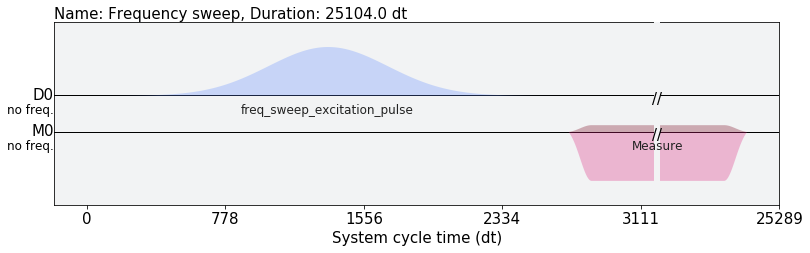

In [144]:
schedule.draw(label=True)

In [145]:
from qiskit import assemble

num_shots_per_frequency = 1024
frequency_sweep_program = assemble(schedule,
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_frequency,
                                   schedule_los=schedule_frequencies)

In [146]:
job = backend.run(frequency_sweep_program)

In [147]:
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

60be815cdb146e29414bca59
Job Status: job has successfully run


In [148]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

In [15]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

NameError: name 'frequency_sweep_results' is not defined

In [199]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [208]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [6, 4.970, 0.5,0] # initial parameters for curve_fit
                                )

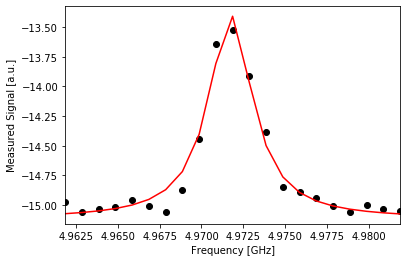

In [209]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [210]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 8)} GHz to {round(rough_qubit_frequency/GHz, 8)} GHz.")

We've updated our qubit frequency estimate from 4.97186026 GHz to 4.97174481 GHz.


In [211]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `measure`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [212]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.
rabi_schedules = []
for drive_amp in drive_amps:
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, amp=drive_amp, 
                                    sigma=drive_sigma, name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule = pulse.Schedule(name=f"Rabi drive amplitude = {drive_amp}")
    this_schedule += Play(rabi_pulse, drive_chan)
    # Reuse the measure instruction from the frequency sweep experiment
    this_schedule += measure << this_schedule.duration
    rabi_schedules.append(this_schedule)

C:\Users\itong\anaconda3\lib\site-packages\qiskit\pulse\schedule.py:1539: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  DeprecationWarning)


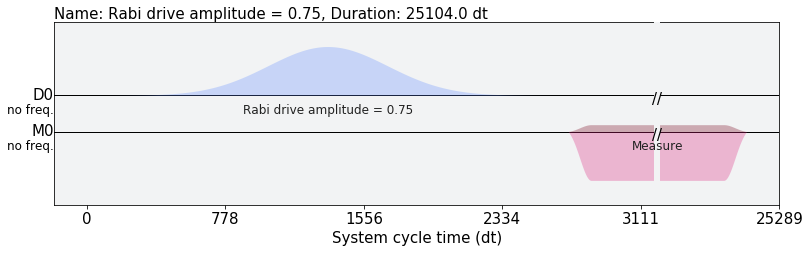

In [213]:
rabi_schedules[-1].draw(label=True)

In [214]:
# Assemble the schedules into a Qobj
num_shots_per_point = 1024

rabi_experiment_program = assemble(rabi_schedules,
                                   backend=backend,
                                   meas_level=1,
                                   meas_return='avg',
                                   shots=num_shots_per_point,
                                   schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                * num_rabi_points)

In [215]:
print(job.job_id())
job = backend.run(rabi_experiment_program)
job_monitor(job)

60be815cdb146e29414bca59
Job Status: job has successfully run


In [216]:
rabi_results = job.result(timeout=120)

In [217]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

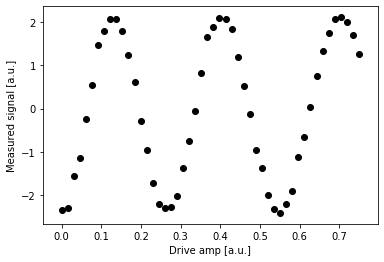

In [218]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit]*scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

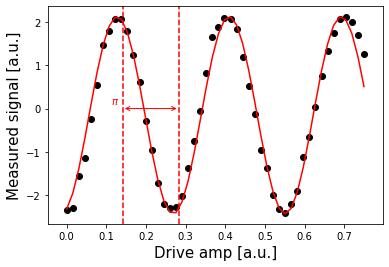

In [219]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [4, -4, 0.4, 2*np.pi])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [220]:
pi_amp_01 = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp_01}")

Pi Amplitude = 0.14137223267354437


In [221]:
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_01, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_01')

In [222]:
# Create the two schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan) 
one_schedule |= measure << one_schedule.duration

C:\Users\itong\anaconda3\lib\site-packages\qiskit\pulse\schedule.py:1539: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  DeprecationWarning)


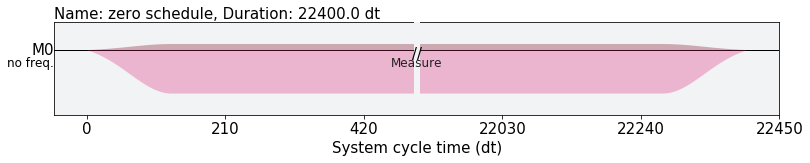

In [223]:
zero_schedule.draw(label=True)

C:\Users\itong\anaconda3\lib\site-packages\qiskit\pulse\schedule.py:1539: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  DeprecationWarning)


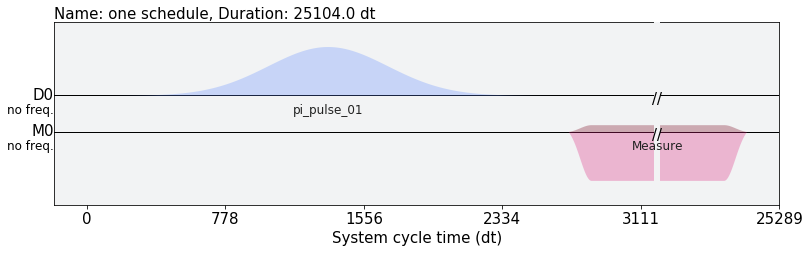

In [224]:
one_schedule.draw(label=True)

In [225]:
# Assemble the schedules into a program
IQ_01_program = assemble([zero_schedule, one_schedule],
                          backend=backend,
                          meas_level=1,
                          meas_return='single',
                          shots=NUM_SHOTS,
                          schedule_los=[{drive_chan: rough_qubit_frequency}] * 2)

In [226]:
IQ_01_job = backend.run(IQ_01_program)

In [227]:
print(IQ_01_job.job_id())
job_monitor(IQ_01_job)

60be8fa7ac71df6cf6e6a6b8
Job Status: job has successfully run


In [9]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

In [229]:
# Get job data (single); split for zero and one
IQ_01_data = get_job_data(IQ_01_job, average=False)
zero_data = IQ_01_data[0]
one_data = IQ_01_data[1]

In [12]:
def IQ_01_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for |0>, |1>. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')

    # Plot a large dot for the average result of the zero and one states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1 discrimination", fontsize=15)

In [14]:
x_min = -25
x_max = -5
y_min = -25
y_max = 0
IQ_01_plot(x_min, x_max, y_min, y_max)

NameError: name 'plt' is not defined

In [10]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [233]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  

IQ_01_data = np.concatenate((zero_data_reshaped, one_data_reshaped))
print(IQ_01_data.shape) # verify IQ data shape

(2048, 2)


In [234]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

In [235]:
# construct vector w/ 0's and 1's (for testing)
state_01 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_01 = np.concatenate((state_01, np.ones(NUM_SHOTS)))
print(len(state_01))

# Shuffle and split data into training and test sets
IQ_01_train, IQ_01_test, state_01_train, state_01_test = train_test_split(IQ_01_data, state_01, test_size=0.5)

2048


In [236]:
# Set up the LDA
LDA_01 = LinearDiscriminantAnalysis()
LDA_01.fit(IQ_01_train, state_01_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [237]:
# test on some simple data 
print(LDA_01.predict([[0,0], [10, 0]]))

[0. 1.]


In [238]:
# Compute accuracy
score_01 = LDA_01.score(IQ_01_test, state_01_test)
print(score_01)

0.962890625


In [13]:
# Plot separatrix on top of scatter
def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

IQ_01_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_01, x_min, x_max, y_min, y_max, NUM_SHOTS)

NameError: name 'x_min' is not defined

## Discriminating the |0⟩, |1⟩ and |2⟩ states 

In [240]:
from qiskit.pulse.library import Waveform ## replaced by Wafeform after 0.25.0

In [241]:
def apply_sideband(pulse, freq):
    """Apply a sinusoidal sideband to this pulse at frequency freq.
    Args:
        pulse (SamplePulse): The pulse of interest.
        freq (float): LO frequency for which we want to apply the sweep.
    Return:
        SamplePulse: Pulse with a sideband applied (oscillates at difference between freq and cal_qubit_freq).
    """
    # time goes from 0 to dt*drive_samples, sine arg of form 2*pi*f*t
    t_samples = np.linspace(0, dt*drive_samples, drive_samples)
    sine_pulse = np.sin(2*np.pi*(freq-rough_qubit_frequency)*t_samples) # no amp for the sine
    
    # create sample pulse w/ sideband applied
    # Note: need to make sq_pulse.samples real, multiply elementwise
    sideband_pulse = Waveform(np.multiply(np.real(pulse.samples), sine_pulse), name='sideband_pulse')
    
    return sideband_pulse

In [242]:
def create_excited_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the |1> state. 
    This allows us to obtain the 1->2 frequency. We get from the |0> to |1>
    state via a pi pulse using the calibrated qubit frequency. To do the 
    frequency sweep from |1> to |2>, we use a sideband method by tacking
    a sine factor onto the sweep drive pulse.
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Thrown if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try more than 75 frequencies.
    Returns:
        Qobj: Program for freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
        
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")

    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                        sigma=drive_sigma,
                                        amp=drive_power,
                                        name='base_12_pulse')
    schedules = []
    for jj, freq in enumerate(freqs):
        
        # add sideband to gaussian pulse
        freq_sweep_12_pulse = apply_sideband(base_12_pulse, freq)
        
        # add commands to schedule
        schedule = pulse.Schedule(name="Frequency = {}".format(freq))

        # Add 0->1 pulse, freq sweep pulse and measure
        schedule |= pulse.Play(pi_pulse_01, drive_chan)
        schedule |= pulse.Play(freq_sweep_12_pulse, drive_chan) << schedule.duration 
        schedule |= measure << schedule.duration # shift measurement to after drive pulses

        schedules.append(schedule)

    num_freqs = len(freqs)
    
    # draw a schedule
    display(schedules[-1].draw(channels=[drive_chan, meas_chan], label=True, scale=1.0))
    
    # assemble freq sweep program 
    # Note: LO is at cal_qubit_freq for each schedule; accounted for by sideband
    excited_freq_sweep_program = assemble(schedules,
                                          backend=backend, 
                                          meas_level=1,
                                          meas_return='avg',
                                          shots=NUM_SHOTS,
                                          schedule_los=[{drive_chan: rough_qubit_frequency}]
                                                         * num_freqs)
    
    return excited_freq_sweep_program

The frequency sweep will go from 4.571744810298549 GHz to 5.001744810298549 GHz using 75 frequencies. The drive power is 0.3.


C:\Users\itong\anaconda3\lib\site-packages\qiskit\pulse\schedule.py:1539: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments scale, label, channels are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  DeprecationWarning)


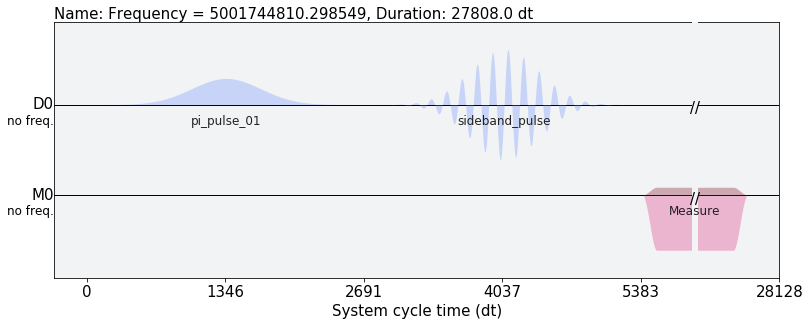

In [243]:
# sweep 400 MHz below 0->1 frequency to catch the 1->2 frequency
num_freqs = 75
excited_sweep_freqs = rough_qubit_frequency + np.linspace(-400*MHz, 30*MHz, num_freqs)
excited_freq_sweep_program = create_excited_freq_sweep_program(excited_sweep_freqs, drive_power=0.3)

# Plot an example schedule to make sure it's valid

In [244]:
excited_freq_sweep_job = backend.run(excited_freq_sweep_program)

In [245]:
print(excited_freq_sweep_job.job_id())
job_monitor(excited_freq_sweep_job)

60be8fbe8585336fcbea6fae
Job Status: job has successfully run


In [246]:
# Get job data (avg)
excited_freq_sweep_data = get_job_data(excited_freq_sweep_job, average=True)

C:\Users\itong\anaconda3\lib\site-packages\numpy\core\_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


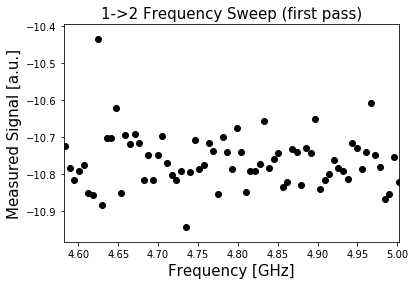

In [247]:
# Note: we are only plotting the real part of the signal
plt.scatter(excited_sweep_freqs/GHz, excited_freq_sweep_data, color='black')
plt.xlim([min(excited_sweep_freqs/GHz)+0.01, max(excited_sweep_freqs/GHz)]) # ignore min point (is off)
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (first pass)", fontsize=15)
plt.show()

In [248]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [249]:
# Prints out relative maxima frequencies in output_data; height gives lower bound (abs val)
def rel_maxima(freqs, output_data, height): 
    """
    Prints out relative maxima frequencies in output_data (can see peaks); height gives upper bound (abs val).
    Be sure to set the height properly or the peak will be ignored!
    Args:
        freqs (list): frequency list
        output_data (list): list of resulting signals
        height (float): upper bound (abs val) on a peak
    Returns:
        list: List containing relative maxima frequencies
    """
    peaks, _ = find_peaks(output_data, height)
    print("Freq. dips: ", freqs[peaks])
    return freqs[peaks]

In [251]:
maxima = rel_maxima(excited_sweep_freqs, np.real(excited_freq_sweep_data), -10.5)
approx_12_freq = maxima

Freq. dips:  [4.62404211e+09]


The frequency sweep will go from 4.604042107595846 GHz to 4.644042107595846 GHz using 75 frequencies. The drive power is 0.3.


C:\Users\itong\anaconda3\lib\site-packages\qiskit\pulse\schedule.py:1539: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments scale, label, channels are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  DeprecationWarning)


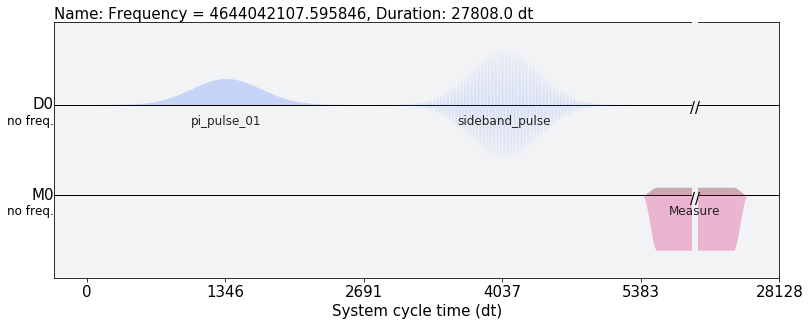

In [252]:
# smaller range refined sweep
num_freqs = 75
refined_excited_sweep_freqs = approx_12_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
refined_excited_freq_sweep_program = create_excited_freq_sweep_program(refined_excited_sweep_freqs, drive_power=0.3)

In [253]:
refined_excited_freq_sweep_job = backend.run(refined_excited_freq_sweep_program)

In [254]:
print(refined_excited_freq_sweep_job.job_id())
job_monitor(refined_excited_freq_sweep_job)

60be9085db146ec4c34bcb7d
Job Status: job has successfully run


In [255]:
# Get the refined data (average)
refined_excited_freq_sweep_data = get_job_data(refined_excited_freq_sweep_job, average=True)

In [258]:
# do fit in Hz
(refined_excited_sweep_fit_params, 
 refined_excited_sweep_y_fit) = fit_function(refined_excited_sweep_freqs,
                                     refined_excited_freq_sweep_data, 
                                     lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                     [3, 4.624*GHz, 0.05*GHz, 3*GHz] # initial parameters for curve_fit
                                     )

C:\Users\itong\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


C:\Users\itong\anaconda3\lib\site-packages\numpy\core\_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


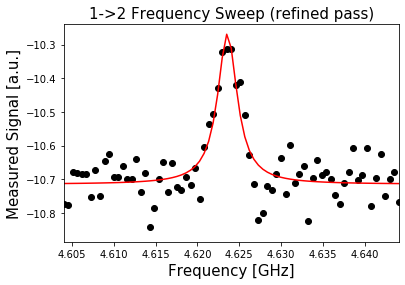

In [259]:
# Note: we are only plotting the real part of the signal
plt.scatter(refined_excited_sweep_freqs/GHz, refined_excited_freq_sweep_data, color='black')
plt.plot(refined_excited_sweep_freqs/GHz, refined_excited_sweep_y_fit, color='red')
plt.xlim([min(refined_excited_sweep_freqs/GHz), max(refined_excited_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep (refined pass)", fontsize=15)
plt.show()

In [260]:
_, qubit_12_freq, _, _ = refined_excited_sweep_fit_params
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")

Our updated estimate for the 1->2 transition frequency is 4.6235818 GHz.


In [261]:
# experimental configuration
num_rabi_points = 75 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 75 amplitudes evenly spaced from 0 to 1.0
drive_amp_min = 0
drive_amp_max = 1.0
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [262]:
# Create schedule
rabi_12_schedules = []

# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    
    base_12_pulse = pulse_lib.gaussian(duration=drive_samples,
                                       sigma=drive_sigma,
                                       amp=drive_amp,
                                       name='base_12_pulse')
    # apply sideband at the 1->2 frequency
    rabi_12_pulse = apply_sideband(base_12_pulse, qubit_12_freq)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(pi_pulse_01, drive_chan) # 0->1
    schedule |= pulse.Play(rabi_12_pulse, drive_chan) << schedule.duration # 1->2 Rabi pulse
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    
    rabi_12_schedules.append(schedule)

In [264]:
# Assemble the schedules into a program
# Note: The LO frequency is at cal_qubit_freq to support the 0->1 pi pulse;
# it is modified for the 1->2 pulse using sidebanding
rabi_12_expt_program = assemble(rabi_12_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: rough_qubit_frequency}]
                                               * num_rabi_points)

In [265]:
rabi_12_job = backend.run(rabi_12_expt_program)

In [266]:
print(rabi_12_job.job_id())
job_monitor(rabi_12_job)

60be916fabced6299d04e86e
Job Status: job has successfully run


In [267]:
# Get the job data (average)
rabi_12_data = get_job_data(rabi_12_job, average=True)

In [268]:
print(len(rabi_12_data)*0.6)

45.0


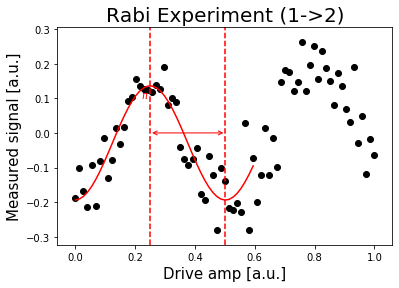

In [269]:
# Note: We only plot the real part of the signal.
rabi_12_data = np.real(baseline_remove(rabi_12_data))
(rabi_12_fit_params, 
 rabi_12_y_fit) = fit_function(drive_amps[:45],
                            rabi_12_data[:45], 
                            lambda x, A, B, drive_12_period, phi: (A*np.cos(2*np.pi*x/drive_12_period - phi) + B),
                            [2, -2.5, 0.4,0.5])

plt.scatter(drive_amps, rabi_12_data, color='black')
plt.plot(drive_amps[:45], rabi_12_y_fit, color='red')

drive_12_period = rabi_12_fit_params[2]
# account for phi in computing pi amp
pi_amp_12 = (drive_12_period/2/np.pi) *(np.pi+rabi_12_fit_params[3])

plt.axvline(pi_amp_12, color='red', linestyle='--')
plt.axvline(pi_amp_12+drive_12_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_12+drive_12_period/2, 0), xytext=(pi_amp_12,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_12-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rabi Experiment (1->2)', fontsize=20)
plt.show()

In [270]:
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(qubit_12_freq/GHz, 7)} GHz.")
print(f"Pi Amplitude (1->2) = {pi_amp_12}")

Our updated estimate for the 1->2 transition frequency is 4.6235818 GHz.
Pi Amplitude (1->2) = 0.2498701051233814


In [271]:
pi_pulse_12 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_12, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_12')
# make sure this pulse is sidebanded
pi_pulse_12 = apply_sideband(pi_pulse_12, qubit_12_freq)

In [272]:
# Create the three schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="zero schedule")
zero_schedule |= measure

# Excited state schedule
one_schedule = pulse.Schedule(name="one schedule")
one_schedule |= pulse.Play(pi_pulse_01, drive_chan)
one_schedule |= measure << one_schedule.duration

# Excited state schedule
two_schedule = pulse.Schedule(name="two schedule")
two_schedule |= pulse.Play(pi_pulse_01, drive_chan)
two_schedule |= pulse.Play(pi_pulse_12, drive_chan) << two_schedule.duration
two_schedule |= measure << two_schedule.duration

In [273]:
# Assemble the schedules into a program
IQ_012_program = assemble([zero_schedule, one_schedule, two_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * 3)

In [274]:
# Assemble the schedules into a program
IQ_012_program = assemble([zero_schedule, one_schedule, two_schedule],
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: rough_qubit_frequency}] * 3)

In [275]:
IQ_012_job = backend.run(IQ_012_program)

In [276]:
print(IQ_012_job.job_id())
job_monitor(IQ_012_job)

60be9206ac71df385ee6a6e9
Job Status: job has successfully run


In [19]:
IQ_012_job_retrieve = backend.retrieve_job('60be9206ac71df385ee6a6e9')
IQ_012_job = IQ_012_job_retrieve 

In [20]:
# Get job data (single); split for zero, one and two
IQ_012_data = get_job_data(IQ_012_job, average=False)
zero_data = IQ_012_data[0]
one_data = IQ_012_data[1]
two_data = IQ_012_data[2]

In [21]:
def IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data), 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    plt.scatter(np.real(mean_two), np.imag(mean_two), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)

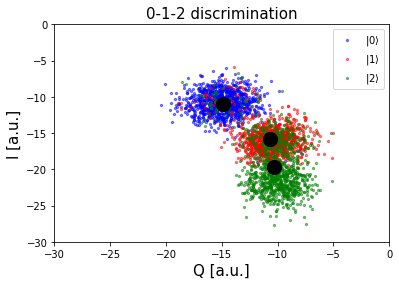

In [22]:
x_min = -30
x_max = 0
y_min = -30
y_max = 0
IQ_012_plot(x_min, x_max, y_min, y_max)

In [23]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  
two_data_reshaped = reshape_complex_vec(two_data)  

IQ_012_data = np.concatenate((zero_data_reshaped, one_data_reshaped, two_data_reshaped))
print(IQ_012_data.shape) # verify IQ data shape

(3072, 2)


In [24]:
print(IQ_012_data[0])
import numpy

numpy.savetxt('0_data.csv', IQ_012_data[0], delimiter=' ', fmt='%f')
numpy.savetxt('1_data.csv', IQ_012_data[1], delimiter=' ', fmt='%f')
numpy.savetxt('2_data.csv', IQ_012_data[2], delimiter=' ', fmt='%f')

[-15.75695189 -11.53307838]


3072
[1. 0. 0.]
0.818359375


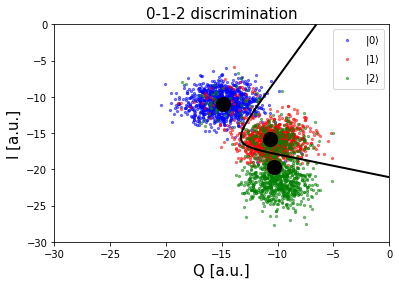

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
# construct vector w/ 0's, 1's and 2's (for testing)
state_012 = np.zeros(NUM_SHOTS) # shots gives number of experiments
state_012 = np.concatenate((state_012, np.ones(NUM_SHOTS)))
state_012 = np.concatenate((state_012, 2*np.ones(NUM_SHOTS)))
print(len(state_012))

# Shuffle and split data into training and test sets
IQ_012_train, IQ_012_test, state_012_train, state_012_test = train_test_split(IQ_012_data, state_012, test_size=0.5)
# Set up the LDA
LDA_012 = LinearDiscriminantAnalysis()
LDA_012.fit(IQ_012_train, state_012_train)
# test on some simple data 
print(LDA_012.predict([[0, 0], [-10, 0], [-15, -5]]))
# Compute accuracy
score_012 = LDA_012.score(IQ_012_test, state_012_test)
print(score_012)
IQ_012_plot(x_min, x_max, y_min, y_max)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

C:\Users\itong\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.83984375


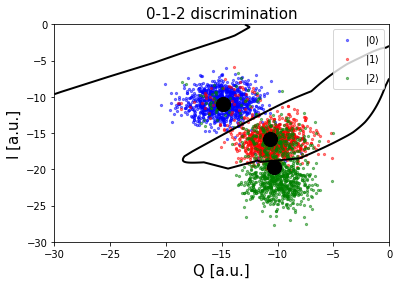

In [27]:
from sklearn.neural_network import MLPClassifier
IQ_012_plot(x_min, x_max, y_min, y_max)
NN_012 = MLPClassifier(solver='lbfgs',max_iter=1000)
NN_012.fit(IQ_012_train, state_012_train)
separatrixPlot(NN_012, x_min, x_max, y_min, y_max, NUM_SHOTS)
print(NN_012.score(IQ_012_test, state_012_test))

0.82421875


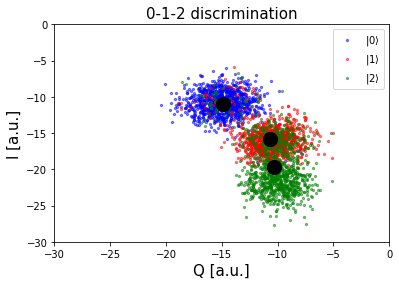

In [28]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
IQ_012_plot(x_min, x_max, y_min, y_max)
QDA_012 = QuadraticDiscriminantAnalysis()
QDA_012.fit(IQ_012_train, state_012_train)
scoreq_012 = QDA_012.score(IQ_012_test, state_012_test)
print(scoreq_012)

C:\Users\itong\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


0.8346354166666666


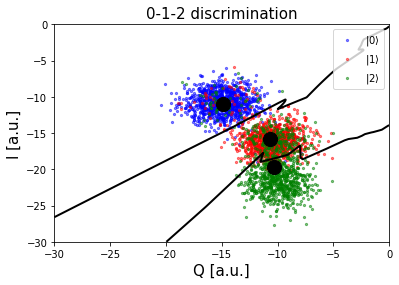

In [29]:
from sklearn.neural_network import MLPClassifier
IQ_012_plot(x_min, x_max, y_min, y_max)
NN_012 = MLPClassifier(hidden_layer_sizes = (100,100,),solver='lbfgs',max_iter=1000)
NN_012.fit(IQ_012_train, state_012_train)
separatrixPlot(NN_012, x_min, x_max, y_min, y_max, NUM_SHOTS)
print(NN_012.score(IQ_012_test, state_012_test))

Use Pytorch to build a classifier ourselfs

In [ ]:
def separatrixPlot(lda, x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

In [52]:
#Set-up a pytorch non-linear discriminte
import torch
import torch.nn as nn

X_train = IQ_012_train
Y_train = state_012_train
X_test = IQ_012_test
Y_test = state_012_test

# Define network dimensions
n_input_dim = X_train.shape[1]
# Layer size
n_hidden =10 # Number of hidden nodes
n_output = 3 # Number of output nodes 

# Build your network
net = nn.Sequential(
    nn.Linear(n_input_dim, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden,50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50, n_output),
    nn.Sigmoid(),
        )
print(net)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): ReLU()
  (6): Linear(in_features=50, out_features=3, bias=True)
  (7): Sigmoid()
)


In [53]:
#Hyperparameters

loss_func = nn.CrossEntropyLoss()
learning_rate = 0.05
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

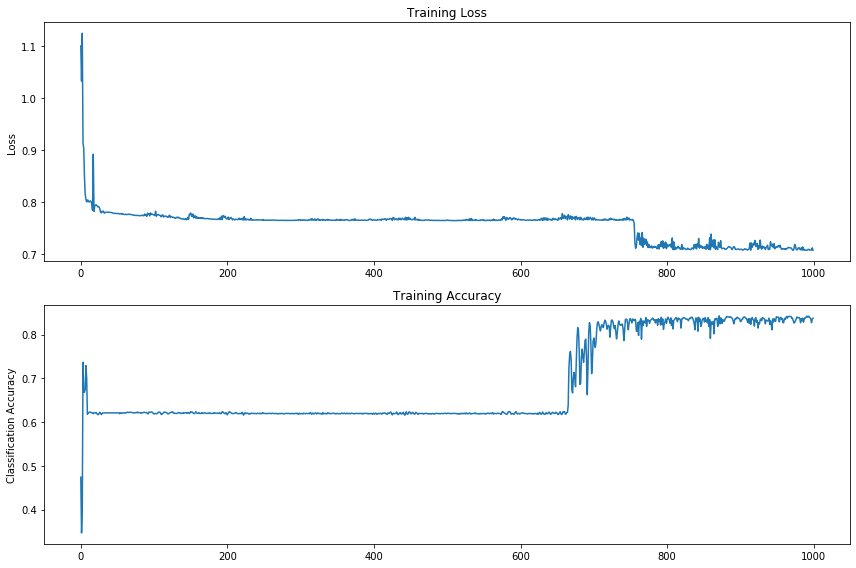

In [54]:
#Train

train_loss = []
accuracy_list = np.zeros((1000,))

iters = 1000
Y_train_t = torch.FloatTensor(Y_train).reshape(-1, 1)
Y_train_t = torch.flatten(Y_train_t)
Y_train_t = Y_train_t.long()

Y_test_t = torch.FloatTensor(Y_test).reshape(-1, 1)
Y_test_t = torch.flatten(Y_test_t)
Y_test_t = Y_test_t.long()

for i in range(iters):
    X_train_t = torch.FloatTensor(X_train)
    y_hat = net(X_train_t)
    #y_hat = y_hat.reshape(-1,1)
    loss = loss_func(y_hat, Y_train_t)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    with torch.no_grad():
        X_test_t = torch.FloatTensor(X_test)
        y_pred = net(X_test_t)
        y_pred_comp = torch.argmax(y_pred, dim=1)
        correct = np.squeeze(y_pred_comp.eq(Y_test_t))
        #correct = (torch.argmax(y_pred, dim=1) == Y_test).type(torch.FloatTensor)
        correct = correct*1
        correct = correct.float()
        accuracy_list[i] = correct.sum()/len(correct)
    
    train_loss.append(loss.item())
    
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].plot(train_loss)
ax[0].set_ylabel('Loss')
ax[0].set_title('Training Loss')

ax[1].plot(accuracy_list)
ax[1].set_ylabel('Classification Accuracy')
ax[1].set_title('Training Accuracy')

plt.tight_layout()
plt.show()

In [55]:
print(accuracy_list)

[0.47395834 0.34635416 0.39453125 0.73697919 0.66861981 0.66796875
 0.67513019 0.72916669 0.69986981 0.61783856 0.62109375 0.62174481
 0.62304688 0.62239581 0.62239581 0.62109375 0.62109375 0.61914062
 0.62109375 0.62109375 0.62109375 0.62174481 0.61914062 0.6171875
 0.6171875  0.61979169 0.62239581 0.62044269 0.6171875  0.61914062
 0.62109375 0.62109375 0.62109375 0.62109375 0.62109375 0.62109375
 0.62109375 0.62109375 0.62109375 0.62109375 0.62109375 0.62109375
 0.62109375 0.62109375 0.62109375 0.62109375 0.62109375 0.62109375
 0.62109375 0.62109375 0.62109375 0.62109375 0.62109375 0.61914062
 0.62109375 0.62109375 0.61979169 0.62109375 0.62109375 0.62109375
 0.62109375 0.62044269 0.62174481 0.62239581 0.62239581 0.62174481
 0.62239581 0.62239581 0.62239581 0.62239581 0.62174481 0.62109375
 0.62109375 0.62109375 0.62174481 0.62109375 0.62174481 0.62304688
 0.62109375 0.62174481 0.62174481 0.62174481 0.62044269 0.62174481
 0.62109375 0.62174481 0.62239581 0.62239581 0.62174481 0.62174

In [92]:
with torch.no_grad():
        X_test_t = torch.FloatTensor(X_test)
        y_pred = net(X_test_t)
        y_pred_comp = torch.argmax(y_pred, dim=1)

def Find_indx(y_pred,X_test):
    zero_list = []
    one_list = []
    two_list = []
    
    zero_data =[]
    one_data =[]
    two_data =[]
    
    real_zero =[]
    im_zero =[]
    real_one =[]
    im_one =[]
    real_two =[]
    im_two =[]
    
    y_pred_num = y_pred.numpy()
    X_test_num = X_test.numpy()
    #Find the indx corresponding to 0,1,2
    for indx,data in enumerate(y_pred_num):
        if y_pred[indx] == 0:
            zero_list.append(indx)
        if y_pred[indx] == 1:
            one_list.append(indx)
        if y_pred[indx] == 2:
            two_list.append(indx)
            
    #Make seperate list of 0,1,2 data
    for indx in zero_list:
        zero_data.append(X_test_num[indx]) 
    for indx in one_list:
        one_data.append(X_test_num[indx]) 
    for indx in two_list:
        two_data.append(X_test_num[indx]) 
    
    #Extract real and img part
    for indx in range(len(zero_data)):
        real_zero.append(zero_data[indx][0])
        im_zero.append(zero_data[indx][1])
    for indx in range(len(one_data)):
        real_one.append(one_data[indx][0])
        im_one.append(one_data[indx][1])
    for indx in range(len(two_data)):
        real_two.append(two_data[indx][0])
        im_two.append(two_data[indx][1])
        
    return(real_zero,im_zero, real_one, im_one, real_two, im_two)

zero_r, zero_i, one_r, one_i, two_r, two_i = Find_indx(y_pred_comp,X_test_t)

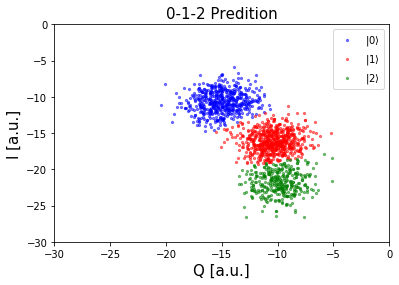

In [104]:
def Pred_IQ_012_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    plt.scatter(zero_r, zero_i, 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter( one_r, one_i, 
                    s=5, cmap='viridis', c='red', alpha=0.5, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(two_r, two_i, 
                    s=5, cmap='viridis', c='green', alpha=0.5, label=r'$|2\rangle$')
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 Predition", fontsize=15)


Pred_IQ_012_plot(x_min, x_max, y_min, y_max)

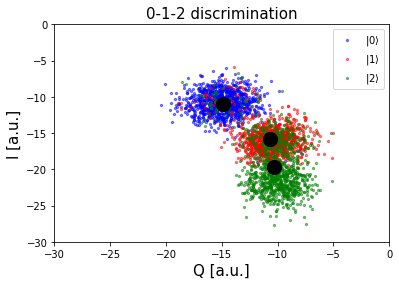

In [103]:
IQ_012_plot(x_min, x_max, y_min, y_max)

### Qudit Gates Class

Currently we only have a few gate operations supported: xcyc (cyclic shift), axcyc (acyclic shift), x01, x12,x02, h01, h12, and h02 gates.

In [255]:
from qiskit.pulse import *
from qiskit.pulse import library as pulse_lib
class QuditGates:
    def __init__(self, pi_amp_01, pi_amp_12, trans_freq_01, trans_freq_12, chan, dt):
#         self.sched = sched
        self.dt = dt
        self.pi_amp_01 = pi_amp_01
        self.pi_amp_12 = pi_amp_12
        self.chan = chan
        self.trans_freq_01 = trans_freq_01
        self.trans_freq_12 = trans_freq_12
        drive_sigma = 0.075*1e-6
        self.drive_sigma_dt = int(drive_sigma/dt) - (int(drive_sigma/dt%16))
        self.drive_samples_dt = 8*self.drive_sigma_dt
        self.pi_pul_01 = pulse_lib.gaussian(duration=self.drive_samples_dt,
                                 amp=self.pi_amp_01,
                                 sigma=self.drive_sigma_dt,
                                 )
        self.base_pulse = pulse_lib.gaussian(duration=self.drive_samples_dt,
                                        sigma=self.drive_sigma_dt,
                                        amp=self.pi_amp_12)
#         pi_pulse_12 = apply_sideband_n(base_pulse, trans_freq_12)
    
    def apply_sideband_n(self, base_pulse, freq):
        t_samples = np.linspace(0, dt*self.drive_samples_dt, num=self.drive_samples_dt)
        sine_pulse = np.sin(2*np.pi*(freq-self.trans_freq_01)*t_samples)
        sideband_pulse = Waveform(np.multiply(np.real(base_pulse.samples), sine_pulse), name='sideband_pulse')
        return sideband_pulse
    
    def xcyc(self):
        '''This the gate corresponding to the operator
        |n> --> |(n+1) mod 3>.'''
        pi_pul_12 = self.apply_sideband_n(self.base_pulse, trans_freq_12)
        with build() as xcyc_pulse:
            play(pi_pul_12, self.chan)
            play(self.pi_pul_01, self.chan)
        sched = Schedule()
        sched += xcyc_pulse
        return sched
    
    def xacyc(self):
        '''This the gate corresponding to the operator
        |n> --> |(n-1) mod 3>.'''
        pi_pul_12 = self.apply_sideband_n(self.base_pulse, trans_freq_12)
        with build as xacyc_pulse:
            play(self.pi_pul_01, self.chan)
            play(pi_pul_12, self.chan)
        sched = Schedule()
        sched += xacyc_pulse
        return sched
    def x01(self, chan):
        '''This the gate corresponding to the operator
        |0> --> |1> and |1> --> |0>.'''
        with pulse.build as x01_pulse:
            pulse.play(self.pi_pul_01, chan)
            sched = Schedule()
        return sched += x01_pulse

    def x12(self, chan):
        '''This the gate corresponding to the operator
        |1> --> |2> and |2> --> |1>.'''
        with pulse.build as x12_pulse:
            pulse.play(self.pi_pul_12, chan)
            sched = Schedule()
        return sched += x12_pulse

    def x02(self, chan):
        '''This the gate corresponding to the operator
        |0> --> |2> and |2> --> |0>.'''
        with pulse.build as x02_pulse:
            pulse.play(self.pi_pul_01, chan)
            pulse.play(self.pi_pul_12, chan)
            pulse.play(self.pi_pul_01, chan)
            sched = Schedule()
        return sched += x02_pulse
    def h01(self):
        qc = QuantumCircuit(1)
        qc.h(0)
        with build(self.backend) as h01_pulse:
            call(qc)
        sched = Schedule()
        sched += h01_pulse
        return sched

    def h12(self):
        qc = QuantumCircuit(1)
        qc.h(0)
        with build(self.backend) as h12_pulse:
            call(qc)
        sched = Schedule()
        sched += h12_pulse
        return sched

    def h02(self):
        qc = QuantumCircuit(1)
        qc.h(0)
        with build(self.backend) as h02_pulse:
            call(qc)
        sched = Schedule()
        sched += Play(self.pi_pul_01,self.chan)
        sched += h02_pulse
        sched += Play(self.pi_pul_01,self.chan)
        return sched

In [363]:
from qiskit.pulse import Schedule

trans_freq_01=4971800930
trans_freq_12=4623781600

pi_amp_01=0.14096173612665405
pi_amp_12=0.2493075855271005
gate=QuditGates(pi_amp_01, pi_amp_12, trans_freq_01, trans_freq_12, drive_chan, dt)
cyclic_shift_sched = Schedule()
cyclic_shift_sched += gate.xcyc()
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])
cyclic_shift_sched |= measure << cyclic_shift_sched.duration

In [364]:
cyclic_shift_program = assemble(cyclic_shift_sched,
                           backend=backend,
                           meas_level=1,
                           meas_return='single',
                           shots=NUM_SHOTS,
                           schedule_los=[{drive_chan: rough_qubit_frequency}])

/Users/mingtsoweii/miniconda3/lib/python3.8/site-packages/qiskit/pulse/schedule.py:1534: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments label are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  warnings.warn('Legacy pulse drawer is deprecated. '


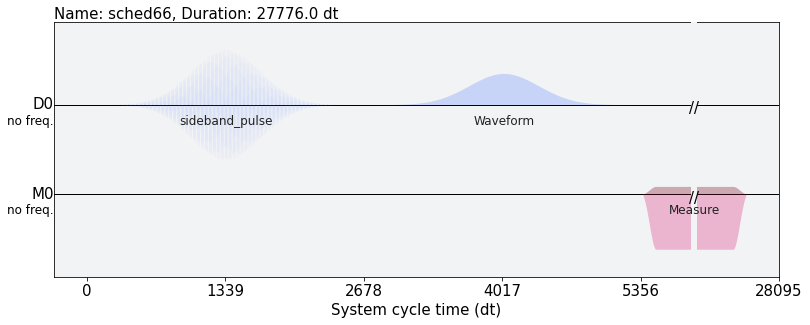

In [365]:
cyclic_shift_sched.draw(label=True)

In [366]:
cyclic_shift_job = backend.run(cyclic_shift_program)

<ipython-input-366-cf96e0c6d087>:1: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  cyclic_shift_job = backend.run(cyclic_shift_program)


In [367]:
job_monitor(cyclic_shift_job)

Job Status: job has successfully run


In [368]:
cyclic_shift_data = get_job_data(cyclic_shift_job, average=False)
cyclic_shift_data

[array([-0.43826857-17.75057102j,  0.77977371-19.09293889j,
        -1.43069538-19.3876931j , ...,  1.24680208-21.17592152j,
        -2.06402891-21.24659521j, -0.23964875-21.21402325j])]

In [369]:
cyclic_shift_reshaped=reshape_complex_vec(cyclic_shift_data[0])

In [370]:
def IQ_012_measure_plot(x_min, x_max, y_min, y_max):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # measured data plotted in blue
    plt.scatter(np.real(cyclic_shift_data), np.imag(cyclic_shift_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label=r'$|0\rangle$')
    mean_data = np.mean(cyclic_shift_data) # takes mean of both real and imaginary parts
    plt.scatter(np.real(mean_data), np.imag(mean_data), 
                s=200, cmap='viridis', c='black',alpha=1.0)
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination of measured data", fontsize=15)

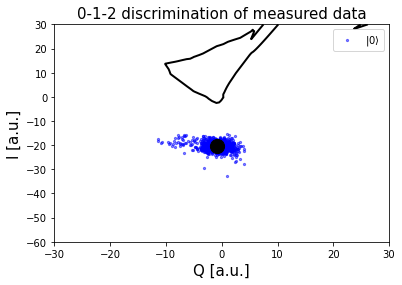

In [374]:
x_min = -30
x_max = 30
y_min = -60
y_max = 30
IQ_012_measure_plot(x_min, x_max, y_min, y_max)
output=NN_012.predict(cyclic_shift_reshaped)
separatrixPlot(NN_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

In [375]:
print(output)

[2. 2. 2. ... 2. 2. 2.]


In [376]:
unique, counts = np.unique(output, return_counts=True)
dict(zip(unique, counts))


{2.0: 1024}

The discriminator seems to be away from the measure data of the cyclic shift. This problem needs to be solved in the future.

### Compare to LDA discriminator

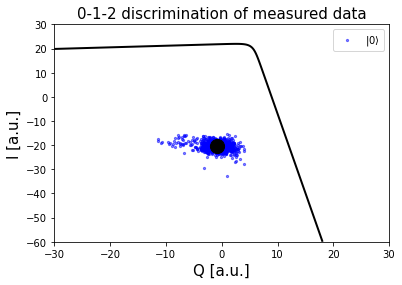

In [378]:
x_min = -30
x_max = 30
y_min = -60
y_max = 30
IQ_012_measure_plot(x_min, x_max, y_min, y_max)
output_LDA=LDA_012.predict(cyclic_shift_reshaped)
separatrixPlot(LDA_012, x_min, x_max, y_min, y_max, NUM_SHOTS)

In [379]:
unique, counts = np.unique(output_LDA, return_counts=True)
dict(zip(unique, counts))

{1.0: 1024}

It has the same issue of classification of the measured data.